In [1]:
!pip install wordcloud

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import numpy as np
import ipywidgets as widgets

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format
from wordcloud import WordCloud, STOPWORDS

In [3]:
entities_df = pd.read_csv("./data/entities_collection.csv")
entities_df["text"] = entities_df.text.str.strip().replace(' ', '_', regex=True).copy()

In [4]:
entities_df.head()

,text,start,end,type,id
0,Angiotensin-converting_enzyme_2,0,31,GENE_OR_GENOME,0
1,ACE2,33,37,GENE_OR_GENOME,0
2,SARS-CoV-2,44,54,CORONAVIRUS,0
3,receptor,55,63,CHEMICAL,0
4,SARS-CoV-2,120,130,CORONAVIRUS,0


In [5]:
entities_df["num_of_words"] = entities_df.text.str.split()

In [6]:
entities_df["num_of_words"] = entities_df["num_of_words"].str.len()

In [7]:
entities_df[entities_df["num_of_words"] > 1]

,text,start,end,type,id,num_of_words
4001,First_two months,0,16,DATE,10,2.00
16863,70 641,201,207,CARDINAL,47,2.00
16884,10 000,1193,1199,CARDINAL,47,2.00
19813,age_55 ± 16_years,835,852,DATE,59,3.00
38545,U = 4,1675,1680,GENE_OR_GENOME,112,3.00
...,...,...,...,...,...,...
9623915,5 µg/m(3)_(1,1328,1340,GENE_OR_GENOME,26981,2.00
9623925,8 µg/m,1649,1655,QUANTITY,26981,2.00
9623929,2 days,1817,1823,DATE,26981,2.00
9640366,2 weeks,817,824,DATE,27365,2.00


#### Group by Type

In [8]:
entities_df.type.value_counts()

CHEMICAL                2076158
GENE_OR_GENOME          1904385
DISEASE_OR_SYNDROME      836989
CARDINAL                 744513
DATE                     665180
                         ...   
EDUCATIONAL_ACTIVITY       1689
LANGUAGE                   1545
PHYSICAL_SCIENCE           1399
GROUP_ATTRIBUTE             850
ARCHAEON                    491
Name: type, Length: 63, dtype: int64

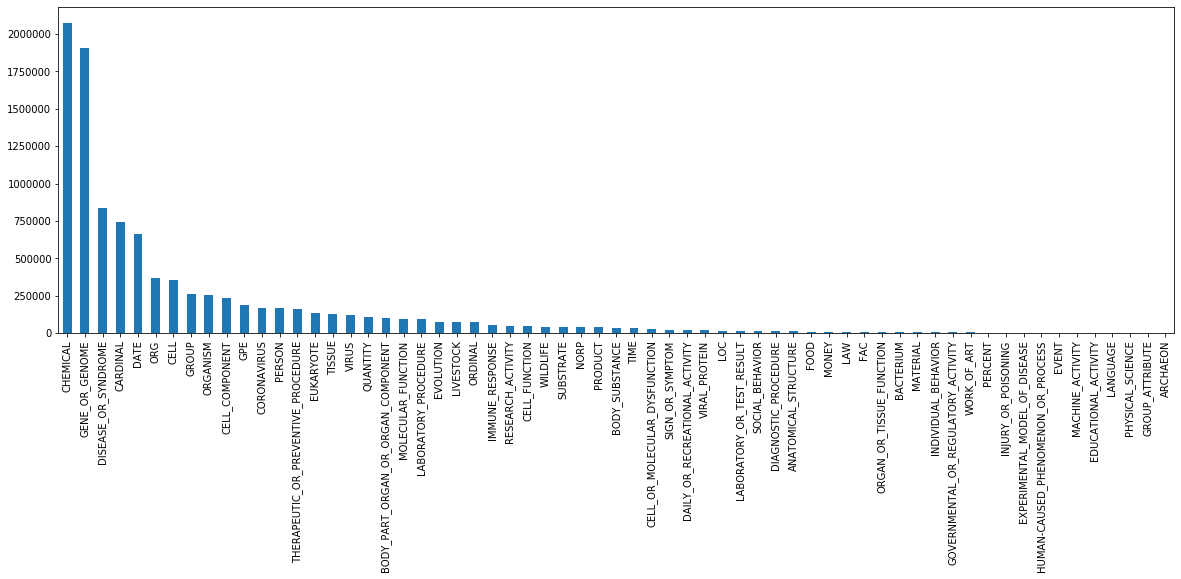

In [9]:
entities_df.type.value_counts().plot.bar(figsize=(20,6))

#### Visualize Wordcloud

In [10]:
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=20, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(24, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#### Visualize by individual document

In [11]:
entities_df.head()

,text,start,end,type,id,num_of_words
0,Angiotensin-converting_enzyme_2,0,31,GENE_OR_GENOME,0,1.00
1,ACE2,33,37,GENE_OR_GENOME,0,1.00
2,SARS-CoV-2,44,54,CORONAVIRUS,0,1.00
3,receptor,55,63,CHEMICAL,0,1.00
4,SARS-CoV-2,120,130,CORONAVIRUS,0,1.00


In [12]:
def get_doc_data_counter(doc_id):
    #### Build a counter for deceased patients
    name_list = entities_df[entities_df.id == doc_id].text.astype(str).to_list()
    names = ' '.join(name_list)
    names_counter = Counter(names.split())
    return names_counter

In [33]:
def get_doc_data(doc_id):
    #### Build a counter for deceased patients
    doc_data = entities_df[entities_df.id == doc_id].copy()
    doc_data["text"] = doc_data["text"].astype(str)
    ent_type_by_doc = doc_data.groupby(["id","type"])["text"].transform(lambda x : ' | '.join(x))
    doc_data["text"] = ent_type_by_doc
    doc_data = doc_data[["id","type","text"]].drop_duplicates()
    doc_data["num_of_text"] = doc_data["text"].str.split("|").str.len()
    doc_data.sort_values(by='type',inplace=True)
    return doc_data
    

In [54]:
def refresh_display(widget):
    #     get the correct Output widget based on the index of the chosen tab
    
    tab_idx = widget['new']
    #document_view.clear_output()
    entity_view.clear_output()
   # print (tab_idx)
    #output_widget = outputs[tab_idx]
    if tab_idx == 0:
        return
        with document_view:
            show_wordcloud(named_counter)
            
    elif tab_idx == 1:
        with entity_view:
            fig = px.scatter(doc_data, x="type", y="num_of_text",color="num_of_text", hover_data=['text'])
            fig.update_xaxes(automargin=True)
            fig.show()

In [55]:
document_view = widgets.Output()
entity_view = widgets.Output()

###List of Patients
doc_list = entities_df.sample(100)["id"].unique().tolist()

dropdown_doc_list = widgets.Dropdown(
    options = doc_list,
    description='Article Id:'
)


def common_filtering(doc_id):
    document_view.clear_output()
    entity_view.clear_output()
    
    named_counter = get_doc_data_counter(doc_id)
    doc_data = get_doc_data(doc_id)
        
    with document_view:
        show_wordcloud(named_counter)
    
    with entity_view:
        fig = px.scatter(doc_data, x="type", y="num_of_text",color="num_of_text", hover_data=['text'])
        fig.update_xaxes(automargin=True)
        fig.show()
        
            

def dropdown_document_view_eventhandler(change):
    common_filtering(change.new)

dropdown_doc_list.observe(dropdown_document_view_eventhandler, names='value')

#display(dropdown_year)
#display(dropdown_purpose)
#display(bounded_num)


item_layout = widgets.Layout(width='auto',margin='120 120 120 120')

input_widgets = widgets.HBox([dropdown_doc_list],layout=item_layout)

tab = widgets.Tab([document_view,entity_view])
tab.set_title(0, 'Article WordCloud')
tab.set_title(1, 'Article Entity Count')


tab.observe(refresh_display, names='selected_index')

#display(tab)

dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)